
 using log10 for visualization 
train without log transforming the memory
Looking at the density for the scatter plot

In [1]:
import pandas as pd
import numpy as np
import json
import os
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

/Users/dn10/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dn10/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json("/Users/dn10/Downloads/Bsub_dataset/filtered_under_5GB.jsonl", lines=True)

In [3]:
with open('/Users/dn10/Downloads/Bsub_dataset/df_without_downsampling.json','r') as f:
    df1 = pd.Index(json.load(f))

In [4]:
df_without_downsampling = df.loc[df1]

In [13]:
print(df_without_downsampling.head())
len(df_without_downsampling)

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0      farm22_1744291338_63_0                24.33681              7168   
1  farm22_1744270877_986673_0                99.56010             40960   
2  farm22_1744290324_999282_0                49.05352             16384   
3  farm22_1744290089_999073_0                40.50170             16384   
4  farm22_1744288795_998111_0                45.76523             16384   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch125/casm/t...               387   
1  #!/bin/bash;#BSUB -o /lustre/scratch127/cellge...              1276   
2  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...              8636   
3  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...              8492   
4  #!/bin/bash;#BSUB -o /lustre/scratch126/pam/te...             11440   

   NUM_EXEC_PROCS  
0               2  
1               4  
2               4  
3               4  
4   

1286631

In [6]:
df_with_downsample = pd.read_json('/Users/dn10/Downloads/Bsub_dataset/df_with_downsampling.json', lines= True)
print(df_with_downsample.head())
len(df_with_downsample)

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0  farm22_1743815745_602372_0                 5.78157              1024   
1  farm22_1744210842_955836_0                 3.74973              1024   
2  farm22_1743817460_603861_0                 2.29569              1024   
3  farm22_1743705461_221976_0                 1.15497              1024   
4  farm22_1743742767_425321_0                 0.49487              1024   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...                 1   
1  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
2  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
3  #!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...                 1   
4  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   

   NUM_EXEC_PROCS  
0               1  
1               1  
2               1  
3               1  
4   

69648

In [8]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-TinyBERT-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-TinyBERT-L6-v2')
encoded_input = tokenizer(df['Command'][0], padding=True, truncation=True, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
print(encoded_input[0])


Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [9]:
# Tokenize each command in the DataFrame
def get_embedding(command):
    encoded_input = tokenizer(command, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform mean pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    # Return the sentence embedding (flattened to 1D tensor)
    return embeddings

In [18]:
df_with_downsample['Embeddings']= df_with_downsample['Command'].apply(lambda x : get_embedding(x))

In [29]:
print(df_with_downsample.head())

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0  farm22_1743815745_602372_0                 5.78157              1024   
1  farm22_1744210842_955836_0                 3.74973              1024   
2  farm22_1743817460_603861_0                 2.29569              1024   
3  farm22_1743705461_221976_0                 1.15497              1024   
4  farm22_1743742767_425321_0                 0.49487              1024   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...                 1   
1  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
2  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
3  #!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...                 1   
4  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   

   NUM_EXEC_PROCS                                         Embeddings  
0               1  [[tensor(-0.42

In [32]:
#saving the embedding 
embedding = df_with_downsample['Embeddings'].to_list()
embedding_series = [e.tolist() for e in embedding]

In [33]:
# Convert tensors to lists for JSON serialization
with open('/Users/dn10/Downloads/Bsub_dataset/embedding.json', 'w') as f:
    json.dump(embedding_series, f)

In [10]:
with open('/Users/dn10/Downloads/Bsub_dataset/embedding.json','r')as f:
    load_embedding = json.load(f)

In [11]:
new_embedding = torch.tensor(load_embedding)

df_with_downsample['Embeddings'] = list(new_embedding)


In [14]:
print(df_with_downsample.head())

                          _id  Job_Efficiency_Percent  MEM_REQUESTED_MB  \
0  farm22_1743815745_602372_0                 5.78157              1024   
1  farm22_1744210842_955836_0                 3.74973              1024   
2  farm22_1743817460_603861_0                 2.29569              1024   
3  farm22_1743705461_221976_0                 1.15497              1024   
4  farm22_1743742767_425321_0                 0.49487              1024   

                                             Command  MAX_MEM_USAGE_MB  \
0  #!/bin/bash;#BSUB -o /lustre/scratch126/casm/t...                 1   
1  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
2  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   
3  #!/bin/bash;#BSUB -o /lustre/scratch127/pam/te...                 1   
4  #!/bin/bash;#BSUB -o /lustre/scratch125/pam/pr...                 1   

   NUM_EXEC_PROCS                                         Embeddings  
0               1  [[tensor(-0.42

Embeddings are generated for each command in the df which is downsampled and stored in a different column called 'Embeddings'. 

In [15]:
df_with_downsample.shape

(69648, 7)

In [17]:
def prepare_data(df):
    X = np.array([np.array([tensor.item() for tensor in emb[0]]) for emb in df["Embeddings"]])
    y = df["MAX_MEM_USAGE_MB"].values
    
    return X, y
X_train, y_train, = prepare_data(df_with_downsample)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (69648, 768), y_train shape: (69648,)


In [18]:
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model
model = train_model(X_train, y_train)

In [70]:
def evaluate_model(model, X, y, dataset_label=""):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred) 

    print(f"{dataset_label} R²: {r2:.4f}")
    print(f"{dataset_label} RMSE: {rmse:.4f}")

    return y_pred, r2
y_train_pred, r2 = evaluate_model(model, X_train, y_train, "Train")

Train R²: 0.8183
Train RMSE: 12108.1949


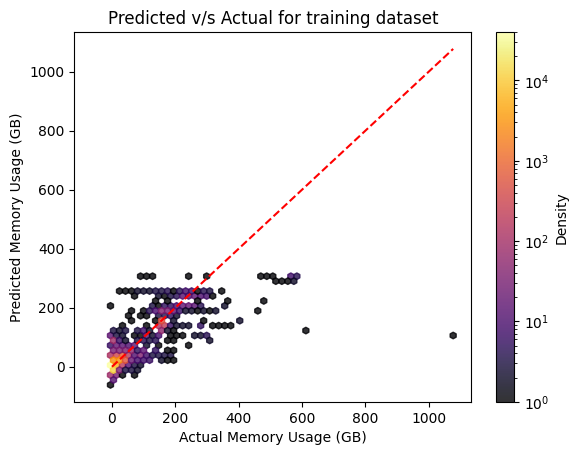

In [55]:
y_actual= y_train/1024
y_predict = y_train_pred/1024

x_extent = [min(y_actual.min(), y_predict.min()), max(y_actual.max(), y_predict.max())]
y_extent = [min(y_actual.min(), y_predict.min()), max(y_actual.max(), y_predict.max())]
plt.hexbin(y_actual, y_predict, gridsize=60, cmap='inferno', alpha=0.8, mincnt=1, bins='log',extent= (x_extent + y_extent))
plt.colorbar(label='Density')
plt.xlabel("Actual Memory Usage (GB)")
plt.ylabel("Predicted Memory Usage (GB)")
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'r--', label='Ideal')
# plt.xlim([min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())])
# plt.ylim([min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())])
plt.title("Predicted v/s Actual for training dataset")
plt.show()

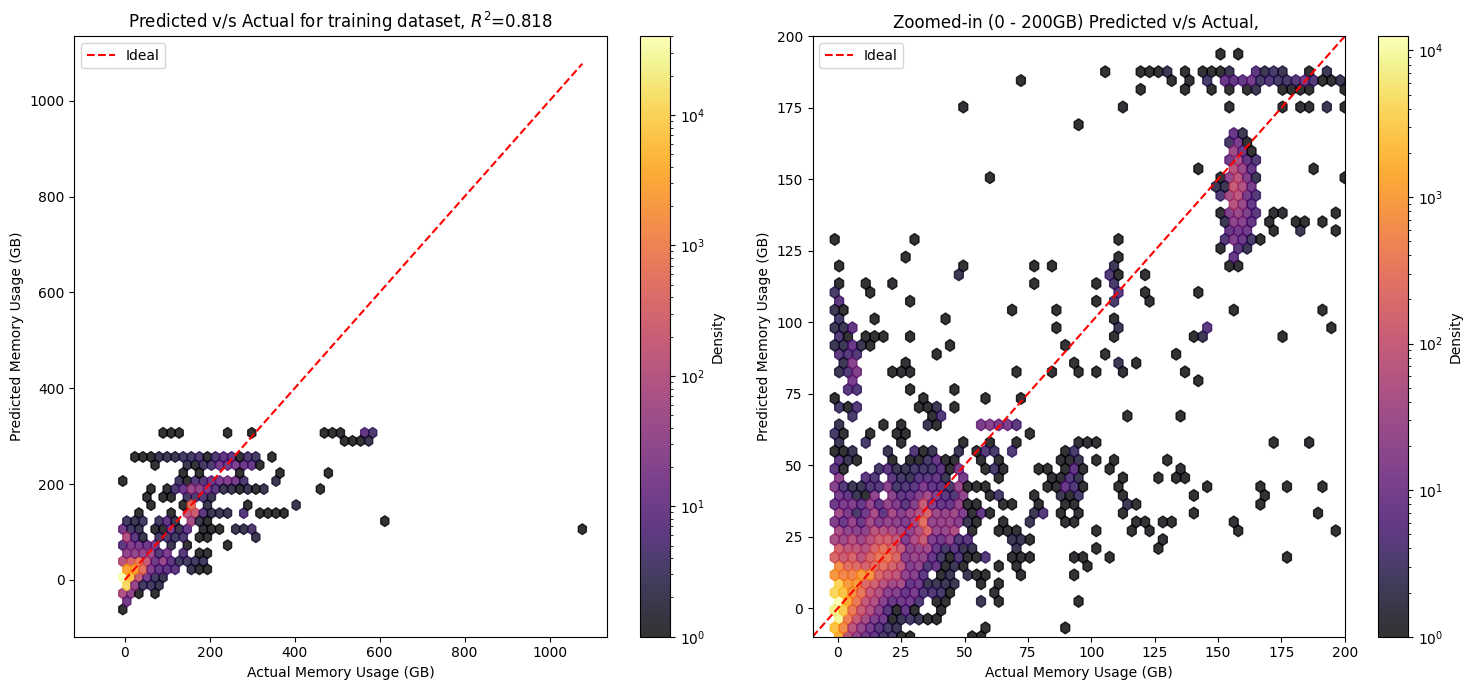

In [ ]:
import matplotlib.pyplot as plt

# Define the extent for the main plot and zoomed-in plot
x_extent = [min(y_actual.min(), y_predict.min()), max(y_actual.max(), y_predict.max())]
y_extent = [min(y_actual.min(), y_predict.min()), max(y_actual.max(), y_predict.max())]

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# First subplot: full plot
axes[0].hexbin(y_actual, y_predict, gridsize=60, cmap='inferno', alpha=0.8, mincnt=1, bins='log', extent=(x_extent + y_extent))
axes[0].set_xlabel("Actual Memory Usage (GB)")
axes[0].set_ylabel("Predicted Memory Usage (GB)")
axes[0].set_title(f"Predicted v/s Actual for training dataset, $R^2$={r2:.3f}")
axes[0].plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'r--', label='Ideal')
axes[0].legend(loc='upper left')
fig.colorbar(axes[0].collections[0], ax=axes[0], label='Density')

# Second subplot: zoomed-in plot (0 to 200 GB)
zoom_extent = [-10, 200, -10, 200]
axes[1].hexbin(y_actual, y_predict, gridsize=60, cmap='inferno', alpha=0.8, mincnt=1, bins='log', extent=zoom_extent)
axes[1].set_xlabel("Actual Memory Usage (GB)")
axes[1].set_ylabel("Predicted Memory Usage (GB)")
axes[1].set_title("Zoomed-in (0 - 200GB) Predicted v/s Actual")
axes[1].plot([-10,200],[-10,200], 'r--', label='Ideal')
plt.xlim([-10, 200])
plt.ylim([-10, 200])
axes[1].legend(loc='upper left')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Density')

# Adjust the layout to make it look nice
plt.tight_layout()
plt.show()


In [ ]:
df_without_downsampling['Embeddings']= df_without_downsampling['Command'].apply(lambda x : get_embedding(x))

In [75]:
new_embedding = torch.tensor(load_embedding)

df_without_downsampling['Embeddings'] = list(new_embedding)


ValueError: Length of values (69648) does not match length of index (1286631)

In [ ]:
X_test, y_test, = prepare_data(df_without_downsampling)
y_test_pred = evaluate_model(model, X_test, y_test, "Test")

Test R²: 0.8480
Test RMSE: 10310.9327
